In [66]:
import os
import argparse
import cv2
import sys
import numpy as np
import insightface
from tqdm import tqdm
from insightface.app import FaceAnalysis 
import pickle
import time
from leech import Leech
import sklearn
import math
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


app = FaceAnalysis(providers=['CPUExecutionProvider'])

app.prepare(ctx_id=0)

#feret
#def get_name(s):
#    return s[:5] 

#lfw
def get_name(s):
    return s[:-9] 


def get_names_vecs(folder):

    cache_file = 'embedding_'+folder
    if os.path.exists(cache_file):
        print('load from cache')
        data = pickle.load(open(cache_file,'rb'))
        names, vecs = data
        return names, vecs 
    
    names = []
    vecs = []
    name_list=[]
    cnt=0
    for f in os.listdir(folder):
        if f[-3:]=='jpg':
            name_list.append(f)

    for name in tqdm(name_list):
        img = cv2.imread(folder +'/'+ name)
        #print(folder+name)
        faces = app.get(img)
        if len(faces)!=1:
            continue
        
        img_embedding = faces[0].normed_embedding
        names.append(get_name(name))
        vecs.append(img_embedding)
    
    data = (names, vecs)
    pickle.dump(data,open(cache_file,'wb'))
    
    return names,vecs

names, vecs = get_names_vecs('feret')

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/kzoacn/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/kzoacn/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/kzoacn/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/kzoacn/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/kzoacn/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
se

In [67]:
alpha = 2**20

def round(v):
    return [int(x*alpha) for x in v]
    
def distance(v1,v2):
    l=0
    r=10
    T=20
    v=[]
    for i in range(len(v1)):
        v.append(v1[i]-v2[i])
    
    while len(v)%24!=0:
        v.append(0)
    
    v=round(v)
    for _ in range(T):
        mid = (l+r)/2
        is_left = False
        
        for i in range(len(v)//24):
            z = Leech.decode(v[i*24:i*24+24],mid*alpha)
            if z.any():
                is_left=True
                break

        if is_left:
            l=mid
        else:
            r=mid
            
    return l

In [68]:
#pca = PCA(n_components=24)
#pca.fit(vecs)
#vecs_new = pca.transform(vecs)


In [69]:
"""
for i in range(len(names)):
    if get_name(names[i])==get_name(names[0]):
        print(distance(vecs[0],vecs[i]))

print('-'*20)

for i in range(20):
    if get_name(names[i])!=get_name(names[0]):
        print(distance(vecs[0],vecs[i]))
"""

"\nfor i in range(len(names)):\n    if get_name(names[i])==get_name(names[0]):\n        print(distance(vecs[0],vecs[i]))\n\nprint('-'*20)\n\nfor i in range(20):\n    if get_name(names[i])!=get_name(names[0]):\n        print(distance(vecs[0],vecs[i]))\n"

In [80]:

def read_distance(file):
    distances = []
    names = []
    with open(file) as f:
        lines = f.readlines()
        for line in lines:
            tokens = line.split()
            name = tokens[0]
            dis = [float(x) for x in tokens[1:]]
            distances.append(dis)
            names.append(name)
    return names, distances


In [81]:
def get_roc(names,distances):

    y_true=[]
    y_score=[]
    
    for i in range(len(names)):
        for j in range(i+1,len(names)):
            y_true.append(1 if get_name(names[i])==get_name(names[j]) else 0)
            y_score.append(-distances[i][j])   
    
    fpr, tpr, thresholds =  sklearn.metrics.roc_curve(y_true,y_score,pos_label=1)
    #plt.plot(fpr,tpr)
    return fpr, tpr, thresholds

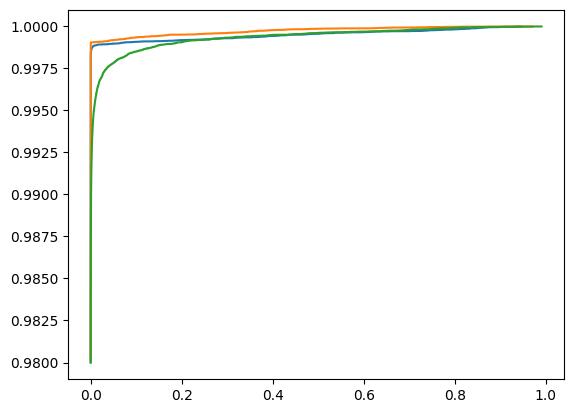

In [83]:
def crop(fpr,tpr,low=0.98,high=1):
    new_fpr = []
    new_tpr = []
    for i in range(len(fpr)):
        if tpr[i]>low and tpr[i]<high:
           new_fpr.append(fpr[i]) 
           new_tpr.append(tpr[i])
    return new_fpr, new_tpr


names, distances = read_distance('distance_le_lfw')
fpr, tpr, thresholds = get_roc(names,distances)
fpr, tpr = crop(fpr,tpr)
plt.plot(fpr,tpr)


names, distances = read_distance('distance_l2_lfw')
fpr, tpr, thresholds = get_roc(names,distances)
fpr, tpr = crop(fpr,tpr)
plt.plot(fpr,tpr)


names, distances = read_distance('distance_linf_lfw')
fpr, tpr, thresholds = get_roc(names,distances)
fpr, tpr = crop(fpr,tpr)
plt.plot(fpr,tpr)